Tareas por hacer:

- Explicar el código en markdown
- Añadir el callback para la optimización (creo que esto es trivial, solo que me parece que como estaba hecho es engorroso de más y le quiero dar una vuelta)
- Traducir las rutinas para evaluar el valor esperado con circuitos cuánticos
- Traducir la carga de los pesos de Boltzmann

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as ss
from scipy.optimize import minimize
from Hubbard_module import *
from entforg import *

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.synthesis import MatrixExponential, LieTrotter
ME = MatrixExponential()

In [2]:
'De momento esto no hace falta que esté en el notebook, pero lo dejo aquí por si acaso'

#from qiskit_nature.second_q.operators import FermionicOp
#a = lambda i: FermionicOp({"-_%i" % i: 1.}, num_spin_orbitals=N_sites) 
#a_dag = lambda i: a(i).adjoint()

'De momento esto no hace falta que esté en el notebook, pero lo dejo aquí por si acaso'

In [3]:
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian
w_1=2*np.pi*400*(3.44-5)
w_2=2*np.pi*400*(7.4-5)
t=2*np.pi*2.32/2

epsilon_1=w_1+t
epsilon_2=w_2+t
c=(w_1/2+w_2/2+t/2)
C=np.sqrt((epsilon_1-epsilon_2)**2/4+t**2)
lamda_pos=-(epsilon_1+epsilon_2)/2+C
lamda_neg=-(epsilon_1+epsilon_2)/2-C
D_pos=np.sqrt((lamda_pos+epsilon_2)**2+t**2)
D_neg=np.sqrt((lamda_neg+epsilon_2)**2+t**2)

A_11=-D_neg/(2*C)
A_12=D_pos/(2*C)
A_21=(lamda_pos+epsilon_2)*D_neg/(2*C*t)
A_22=-(lamda_neg+epsilon_2)*D_pos/(2*C*t)

omega_1=lamda_neg+2*t*(A_11**2*A_21**2+A_11*A_12*A_21*A_22)
omega_2=lamda_pos+2*t*(A_12**2*A_22**2+A_11*A_12*A_21*A_22)
U=2*t*(A_11**2*A_22**2+A_21**2*A_12**2-2*A_11*A_12*A_21*A_22)

omega=np.array([omega_1,omega_2])
# print(c)
# hamil=np.array([[-(w_1+J_rad/2), J_rad/2],[J_rad/2,-(w_2+J_rad/2)]])

In [4]:
import numpy as np
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
JW = JordanWignerMapper()

def H(omega,U, N_sites):
    a = lambda i: FermionicOp({"-_%i" % i: 1.}, num_spin_orbitals=N_sites)
    a_dag = lambda i: a(i).adjoint()
    H_hopping=sum([omega[k]*a_dag(k)@a(k) for k in range(N_sites)])
    H_U=U*a_dag(0)@a(0)@a_dag(1)@a(1)
    H=JW.map((H_hopping+H_U).simplify().normal_order())
    return H.chop()


In [5]:
H(omega,0,2)

SparsePauliOp(['II', 'IZ', 'ZI'],
              coeffs=[-1062.86362656+0.j,  3019.57586369+0.j, -1956.71223713+0.j])

Define parameters

In [6]:
N_sites=2
omega=omega/1000
U=U/1000
H_q=H(omega,U,N_sites)
print(H_q)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[-1.05921938+0.j,  3.01593162+0.j, -1.96035648+0.j,  0.00364425+0.j])


In [7]:
# Diagonalize the Hamiltonian
H_matrix = H_q.to_matrix()
E_L, U_L = np.linalg.eigh(H_matrix)

In [8]:
# Create H_L and H_R
identity = SparsePauliOp.from_list([('I'*N_sites, 1)])
H_L = H_q^identity                 # H_L = H \otimes I
H_R = (identity^H_q).conjugate()   # H_R = I \otimes H*

In [9]:
betas = np.linspace(0.1, 20, 30)
overlaps = np.zeros(len(betas))

for i, beta in enumerate(betas):
    print(i, beta)
    # Create the interaction Hamiltonian
    H_int_q=create_H_int(beta,omega,N_sites)
    H_int_q = quita_Z(JW.map(create_H_int(beta, omega, N_sites)))

    # Create the total Hamiltonian
    H_tot = H_L + H_R + H_int_q
    H_tot_matrix = np.round(H_tot.to_matrix(sparse=True), 8)
    H_tot_matrix.eliminate_zeros()

    # Diagonalize the total Hamiltonian. This is a huge matrix, as its defined in the doubled space,
    # and we are only interested in its ground state, so we use sparse diagonalization
    E_tot, U_tot = ss.linalg.eigsh(H_tot_matrix, k=1, which='SA')

    # Compute the ground state
    GS = U_tot[:, 0]

    # Compute the TFD state
    TFD = get_TFD(beta, U_L, np.conj(U_L), E_L)[0]

    
    '''# Use a truncated TFD state
    mask = np.argsort(E_L)[:10] #These are the indices of the eigenstates to keep, in this case, the 10 lowest energy eigenstates
    TFD = get_TFD_trunc(beta, U_L, np.conj(U_L), E_L, mask)[0]'''
    
    overlaps[i] = np.abs(np.dot(np.conj(GS), TFD))

0 0.1
1 0.786206896551724
2 1.4724137931034482
3 2.1586206896551725
4 2.8448275862068964
5 3.53103448275862
6 4.2172413793103445
7 4.903448275862068
8 5.589655172413792
9 6.275862068965516
10 6.96206896551724
11 7.648275862068965
12 8.33448275862069
13 9.020689655172413
14 9.706896551724137
15 10.39310344827586
16 11.079310344827585
17 11.765517241379309
18 12.451724137931032
19 13.137931034482756
20 13.82413793103448
21 14.510344827586206
22 15.19655172413793
23 15.882758620689653
24 16.56896551724138
25 17.255172413793105
26 17.94137931034483
27 18.627586206896552
28 19.313793103448276
29 20.0


In [10]:
H_tot

SparsePauliOp(['IIII', 'IZII', 'ZIII', 'ZZII', 'IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IIII'],
              coeffs=[-1.05921938+0.j,  3.01593162+0.j, -1.96035648+0.j,  0.00364425+0.j,
 -1.05921938-0.j,  3.01593162-0.j, -1.96035648-0.j,  0.00364425-0.j,
  0.        +0.j])

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(betas, overlaps)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle GS | TFD \rangle|$')


Text(0, 0.5, '$|\\langle GS | TFD \\rangle|$')

# Optimization

In [12]:
# Set some fixed value for beta
beta = 1.2253877551020407

# Create the interaction Hamiltonian
H_int_q = quita_Z(JW.map(create_H_int(beta, omega, N_sites)))

# Create the total Hamiltonian
H_tot = H_L + H_R + H_int_q
H_tot_matrix = H_tot.to_matrix(sparse=True)
H_tot_matrix.eliminate_zeros()

# Diagonalize the total Hamiltonian
E_tot, U_tot = ss.linalg.eigsh(H_tot_matrix, k=2, which='SA')

# Compute the ground state
GS = U_tot[:, 0]

In [13]:
E_tot

array([-12.15069592,  -8.15769608])

In [14]:
TFD = get_TFD(beta, U_L, np.conj(U_L), E_L)[0]

In [15]:
print(np.abs(np.dot(np.conj(GS), TFD)))
print(np.abs(np.dot(np.conj(TFD), GS)))

0.9999998882901742
0.9999998882901742


Define the ansatz

In [16]:
def H_1(omega, N_sites):
    a = lambda i: FermionicOp({"-_%i" % i: 1.}, num_spin_orbitals=N_sites)
    a_dag = lambda i: a(i).adjoint()
    H_hopping=sum([omega[k]*a_dag(k)@a(k) for k in range(N_sites)])
    H=JW.map((H_hopping).simplify().normal_order())
    return H.chop()

def H_2(U, N_sites):
    a = lambda i: FermionicOp({"-_%i" % i: 1.}, num_spin_orbitals=N_sites)
    a_dag = lambda i: a(i).adjoint()
    H_U=U*a_dag(0)@a(0)@a_dag(1)@a(1)
    H=JW.map((H_U).simplify().normal_order())
    return H.chop()


In [17]:
H_1(omega, N_sites)

SparsePauliOp(['II', 'IZ', 'ZI'],
              coeffs=[-1.06286363+0.j,  3.01957586+0.j, -1.95671224+0.j])

In [18]:
ansatz_U = QuantumCircuit(N_sites)
H_hubbard_comm = H_2(U, N_sites).group_commuting()
H_hopping_comm = H_1(omega, N_sites).group_commuting()
reps = 1
count = 0

for r in range(reps):
    for d in range(len(H_hubbard_comm)):
        ansatz_U.append(PauliEvolutionGate(H_hubbard_comm[d], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
        count += 1
    ansatz_U.append(PauliEvolutionGate(H_hopping_comm[0], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
    count += 1

'''
#En el código antiguo el ansatz estaba definido así, que no es exactamente lo mismo. En beta bajo esto no parece afectar mucho,
# salvo por el hecho de que añade el doble de parámetros. En beta alto, el ansatz de arriba se queda ligeramente por debajo de 1
for r in range(reps):
    for d in range(len(H_hubbard_comm)):
        ansatz_U.append(PauliEvolutionGate(H_hubbard_comm[d], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
        count += 1
        ansatz_U.append(PauliEvolutionGate(H_hopping_comm[0], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
        count += 1
'''
gate_number = ansatz_U.num_parameters

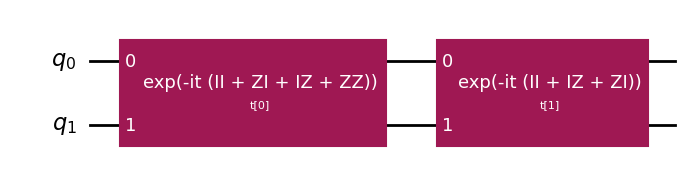

In [19]:
ansatz_U.draw('mpl')

In [20]:
def expectation_classic(x, ansatz_U, cllbck = None):
    U_bound = ansatz_U.assign_parameters(x)
    U_matrix = Operator(U_bound).data
    
    Energies = np.real(np.array([np.dot(np.conj(U_matrix[:, l].T), np.dot(H_matrix, U_matrix[:, l])) for l in range(len(U_matrix))]))
    TFD, _ = get_TFD(beta, U_matrix, np.conj(U_matrix), Energies)
    sTFD = ss.csr_matrix(TFD)
    total_energy = np.real(np.dot(np.conj(sTFD), np.dot(H_tot_matrix, sTFD.T)))[0,0]
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return total_energy

In [21]:
expectation_classic(np.zeros(gate_number), ansatz_U)

np.float64(-12.150694132655653)

In [22]:
def callback(x):
    global x_arr
    x_arr.append(x)

In [23]:
def energia_libre(x, ansatz_U, cllbck = None):
    U_bound = ansatz_U.assign_parameters(x)
    U_matrix = Operator(U_bound).data
    
    Energies = np.real(np.array([np.dot(np.conj(U_matrix[:, l].T), np.dot(H_matrix, U_matrix[:, l])) for l in range(len(U_matrix))]))
    TFD, lambdas = get_TFD(beta, U_matrix, np.conj(U_matrix), Energies)
    sTFD = ss.csr_matrix(TFD)
    energia_libre=-sum(np.exp(-beta*Energies))/beta
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return energia_libre

In [24]:
gate_number=ansatz_U.num_parameters

np.random.seed(42)
x0 = 10**-2*np.random.random(gate_number)
x_arr = []

# Compute the initial energies and decide which states to keep
U_bound = ansatz_U.assign_parameters(x0)
U_matrix = Operator(U_bound).data
Energies = np.real(np.array([np.dot(np.conj(U_matrix[:, l].T), np.dot(H_matrix, U_matrix[:, l])) for l in range(len(U_matrix))]))
# Decide states to keep
n_max = 2**(N_sites)
Mask = np.argsort(Energies)[:n_max]

min_result = minimize(expectation_classic, x0=x0, args=(ansatz_U), tol=1e-4, callback=callback)
min_result2 = minimize(energia_libre, x0=x0, args=(ansatz_U), tol=1e-4, callback=callback)

In [25]:
min_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -12.150694132655651
        x: [ 3.745e-03  9.507e-03]
      nit: 0
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 3
     njev: 1

In [26]:
min_result2

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1347.1469121466316
        x: [ 3.745e-03  9.507e-03]
      nit: 0
      jac: [ 0.000e+00  9.155e-05]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 3
     njev: 1

In [27]:
U_bound = ansatz_U.assign_parameters(min_result.x)
U_matrix = Operator(U_bound).data

Energies = np.real(np.array([np.dot(np.conj(U_matrix[:, l].T), np.dot(H_matrix, U_matrix[:, l])) for l in range(len(U_matrix))]))

TFD_opt = get_TFD(beta, Operator(U_bound).data, np.conj(Operator(U_bound).data), Energies)[0]

In [28]:
np.abs(np.dot(np.conj(GS), TFD_opt))

np.float64(0.9999998882901742)

In [29]:
np.abs(np.dot(np.conj(GS), TFD))

np.float64(0.9999998882901742)

In [30]:
np.abs(np.dot(np.conj(TFD_opt), TFD))

np.float64(1.0000000000000002)

In [31]:
U_bound2 = ansatz_U.assign_parameters(min_result2.x)
U_matrix2 = Operator(U_bound).data

Energies2 = np.real(np.array([np.dot(np.conj(U_matrix2[:, l].T), np.dot(H_matrix, U_matrix2[:, l])) for l in range(len(U_matrix2))]))

TFD_opt2 = get_TFD(beta, Operator(U_bound2).data, np.conj(Operator(U_bound2).data), Energies2)[0]

In [32]:
np.abs(np.dot(np.conj(TFD_opt2), TFD))

np.float64(1.0000000000000002)

# Overlap curve with optimization

In [33]:
N_sites = 2

betas = np.linspace(0.001, 12, 20)
overlaps_GS = np.zeros(len(betas))
overlaps_TFD = np.zeros(len(betas))
overlaps_GSTFD = np.zeros(len(betas))


# Diagonalize the Hamiltonian
H_matrix = H_q.to_matrix()
E_L, U_L = np.linalg.eigh(H_matrix)

# Create H_L and H_R
identity = SparsePauliOp.from_list([('I'*N_sites, 1)])
H_L = H_q^identity                 # H_L = H \otimes I
H_R = (identity^H_q).conjugate()   # H_R = I \otimes H*

ansatz_U = QuantumCircuit(N_sites)
H_hubbard_comm = H_2(U, N_sites).group_commuting()
H_hopping_comm = H_1(omega, N_sites).group_commuting()
reps = 1
count = 0

for r in range(reps):
    for d in range(len(H_hubbard_comm)):
        ansatz_U.append(PauliEvolutionGate(H_hubbard_comm[d], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
        count += 1
    ansatz_U.append(PauliEvolutionGate(H_hopping_comm[0], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
    count += 1

gate_number = ansatz_U.num_parameters


for i, beta in enumerate(betas):
    print('beta:', beta)
    # Create the interaction Hamiltonian
    H_int_q = quita_Z(JW.map(create_H_int(beta, omega, N_sites)))

    # Create the total Hamiltonian
    H_tot = H_L + H_R + H_int_q
    H_tot_matrix = H_tot.to_matrix(sparse=True)
    H_tot_matrix.eliminate_zeros()

    # Diagonalize the total Hamiltonian. This is a huge matrix, as its defined in the doubled space,
    # and we are only interested in its ground state, so we use sparse diagonalization
    E_tot, U_tot = ss.linalg.eigsh(H_tot_matrix, k=2, which='SA')

    # Compute the ground state
    GS = U_tot[:, 0]

    # Compute the TFD state
    TFD_exact = get_TFD(beta, U_L, np.conj(U_L), E_L)[0]

    gate_number=ansatz_U.num_parameters

    x0 = 10**-2*np.random.random(gate_number)

    # Compute the initial energies and decide which states to keep
    U_bound = ansatz_U.assign_parameters(x0)
    U_matrix = Operator(U_bound).data
    Energies = np.real(np.array([np.dot(np.conj(U_matrix[:, l].T), np.dot(H_matrix, U_matrix[:, l])) for l in range(len(U_matrix))]))
    # Decide states to keep
    n_max = 2**(N_sites)
    Mask = np.argsort(Energies)[:n_max]

    min_result = minimize(expectation_classic, x0=x0, args=(ansatz_U), tol=1e-6)

    U_bound = ansatz_U.assign_parameters(min_result.x)
    U_matrix = Operator(U_bound).data

    Energies = np.real(np.array([np.dot(np.conj(U_matrix[:, l].T), np.dot(H_matrix, U_matrix[:, l])) for l in range(len(U_matrix))]))

    TFD_opt = get_TFD(beta, Operator(U_bound).data, np.conj(Operator(U_bound).data), Energies)[0]

    overlaps_GS[i] = np.abs(np.dot(np.conj(GS), TFD_opt))
    overlaps_TFD[i] = np.abs(np.dot(np.conj(TFD_exact), TFD_opt))
    overlaps_GSTFD[i] = np.abs(np.dot(np.conj(GS), TFD_exact))

beta: 0.001
beta: 0.6325263157894737
beta: 1.2640526315789473
beta: 1.895578947368421
beta: 2.5271052631578947
beta: 3.1586315789473685
beta: 3.790157894736842
beta: 4.421684210526316
beta: 5.05321052631579
beta: 5.684736842105264
beta: 6.3162631578947375
beta: 6.947789473684211
beta: 7.579315789473685
beta: 8.210842105263158
beta: 8.842368421052631
beta: 9.473894736842105
beta: 10.105421052631579
beta: 10.736947368421053
beta: 11.368473684210526
beta: 12.0


In [34]:
#plt.figure(figsize=(8, 6))
plt.plot(betas, overlaps_TFD, '*-', label='TFD-Opt')
plt.plot(betas, overlaps_GS, label='GS-Opt')
plt.plot(betas, overlaps_GSTFD, label='GS-TFD')
plt.xlabel(r'$\beta$')
plt.legend()

In [35]:
np.sort(Energies*1000+c)

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [36]:
omega

array([-6.03915173,  3.91342447])

In [37]:
np.sort(E_L*1000+c)

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [38]:
np.sort(E_L)-np.sort(Energies)

array([ 0.0000000e+00, -4.4408921e-16,  0.0000000e+00,  0.0000000e+00])

In [39]:
N_sites = 2

betas = np.linspace(0.001, 12, 20)
overlaps_GS = np.zeros(len(betas))
overlaps_TFD = np.zeros(len(betas))
overlaps_GSTFD = np.zeros(len(betas))


# Diagonalize the Hamiltonian
H_matrix = H_q.to_matrix()
E_L, U_L = np.linalg.eigh(H_matrix)

# Create H_L and H_R
identity = SparsePauliOp.from_list([('I'*N_sites, 1)])
H_L = H_q^identity                 # H_L = H \otimes I
H_R = (identity^H_q).conjugate()   # H_R = I \otimes H*

ansatz_U = QuantumCircuit(N_sites)
H_hubbard_comm = H_2(U, N_sites).group_commuting()
H_hopping_comm = H_1(omega, N_sites).group_commuting()
reps = 1
count = 0

for r in range(reps):
    for d in range(len(H_hubbard_comm)):
        ansatz_U.append(PauliEvolutionGate(H_hubbard_comm[d], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
        count += 1
    ansatz_U.append(PauliEvolutionGate(H_hopping_comm[0], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
    count += 1

gate_number = ansatz_U.num_parameters


for i, beta in enumerate(betas):
    print('beta:', beta)
    # Create the interaction Hamiltonian
    H_int_q = quita_Z(JW.map(create_H_int(beta, omega, N_sites)))

    # Create the total Hamiltonian
    H_tot = H_L + H_R + H_int_q
    H_tot_matrix = H_tot.to_matrix(sparse=True)
    H_tot_matrix.eliminate_zeros()

    # Diagonalize the total Hamiltonian. This is a huge matrix, as its defined in the doubled space,
    # and we are only interested in its ground state, so we use sparse diagonalization
    E_tot, U_tot = ss.linalg.eigsh(H_tot_matrix, k=2, which='SA')

    # Compute the ground state
    GS = U_tot[:, 0]

    # Compute the TFD state
    TFD_exact = get_TFD(beta, U_L, np.conj(U_L), E_L)[0]

    gate_number=ansatz_U.num_parameters

    x0 = 10**-2*np.random.random(gate_number)

    # Compute the initial energies and decide which states to keep
    U_bound = ansatz_U.assign_parameters(x0)
    U_matrix = Operator(U_bound).data
    Energies = np.real(np.array([np.dot(np.conj(U_matrix[:, l].T), np.dot(H_matrix, U_matrix[:, l])) for l in range(len(U_matrix))]))
    # Decide states to keep
    n_max = 2**(N_sites)
    Mask = np.argsort(Energies)[:n_max]

    min_result = minimize(energia_libre, x0=x0, args=(ansatz_U), tol=1e-6)

    U_bound = ansatz_U.assign_parameters(min_result.x)
    U_matrix = Operator(U_bound).data

    Energies = np.real(np.array([np.dot(np.conj(U_matrix[:, l].T), np.dot(H_matrix, U_matrix[:, l])) for l in range(len(U_matrix))]))

    TFD_opt = get_TFD(beta, Operator(U_bound).data, np.conj(Operator(U_bound).data), Energies)[0]

    overlaps_GS[i] = np.abs(np.dot(np.conj(GS), TFD_opt))
    overlaps_TFD[i] = np.abs(np.dot(np.conj(TFD_exact), TFD_opt))
    overlaps_GSTFD[i] = np.abs(np.dot(np.conj(GS), TFD_exact))

beta: 0.001
beta: 0.6325263157894737
beta: 1.2640526315789473
beta: 1.895578947368421
beta: 2.5271052631578947
beta: 3.1586315789473685
beta: 3.790157894736842
beta: 4.421684210526316
beta: 5.05321052631579
beta: 5.684736842105264
beta: 6.3162631578947375
beta: 6.947789473684211
beta: 7.579315789473685
beta: 8.210842105263158
beta: 8.842368421052631
beta: 9.473894736842105
beta: 10.105421052631579
beta: 10.736947368421053
beta: 11.368473684210526
beta: 12.0


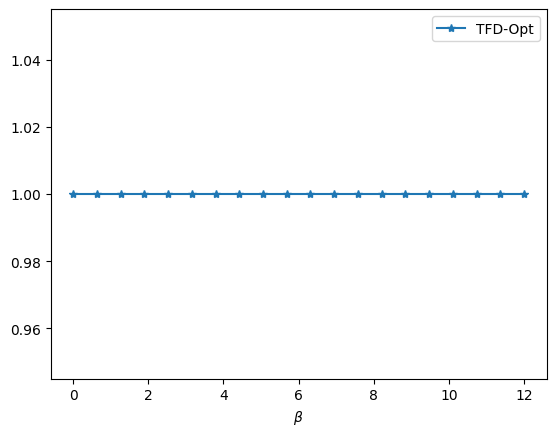

In [46]:
#plt.figure(figsize=(8, 6))
plt.plot(betas, overlaps_TFD, '*-', label='TFD-Opt')
plt.xlabel(r'$\beta$')
plt.legend()
plt.show()

In [41]:
np.sort(Energies*1000+c)

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [42]:
omega

array([-6.03915173,  3.91342447])

In [43]:
np.sort(E_L*1000+c)

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [44]:
np.sort(E_L)-np.sort(Energies)

array([8.8817842e-16, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00])